<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Amirreza Velae
### Student ID: 400102222

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

c:\Users\Amirreza\.conda\envs\deeplearning\Lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

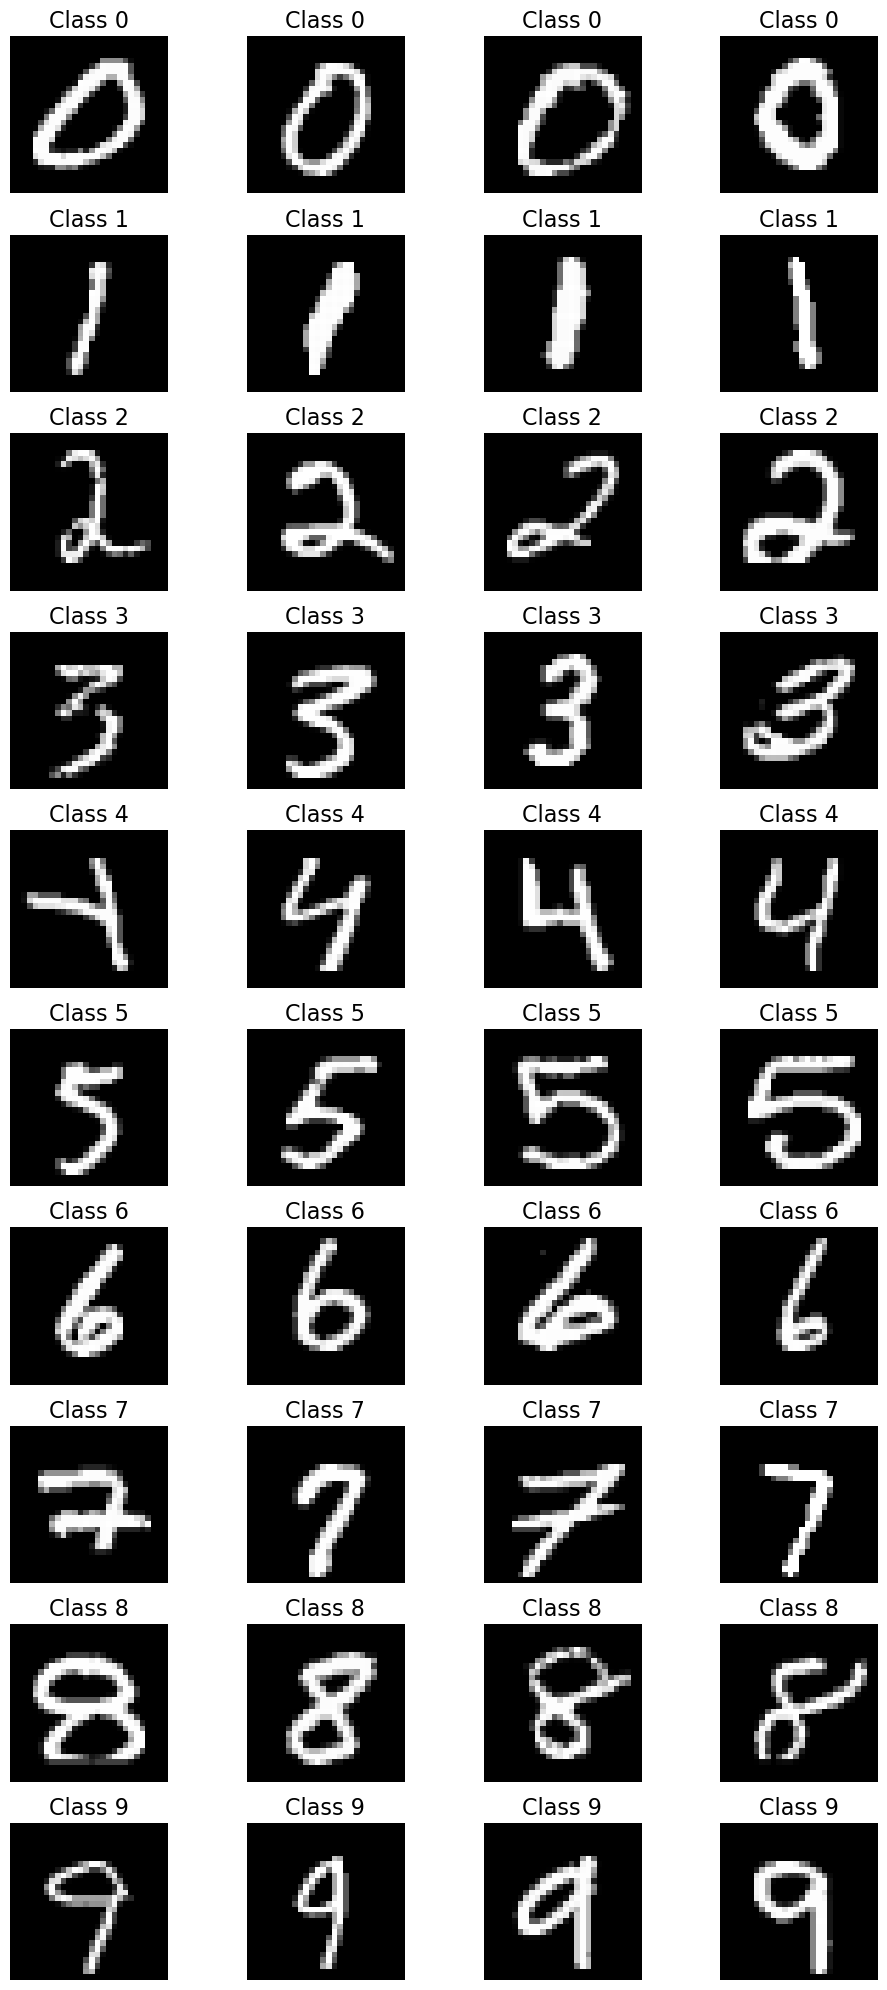

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [5]:
# Define a simple VAE class with MLP architecture for MNIST

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(),
            nn.Linear(input_dim//2, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim//2),
            nn.ReLU(),
            nn.Linear(input_dim//2 , input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        return mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)

    def forward(self, x):
        # TODO: Implement the forward pass
        x = x.flatten(start_dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder(z)
        return x, mu, logvar
        

In [6]:
# Define VAE loss function
def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.mse_loss(recon, data, reduction='sum') / (2*data.var()) * data.shape[1]

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + kl_divergence

In [7]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            optimizer.zero_grad()
            recon, mu, logvar =  model(data)
            # TODO: Flatten the data and recon tensors
            data = data.view(data.size(0), -1)
            recon = recon.view(recon.size(0), -1)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model =  model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 175479.13691666667
Sample Images:


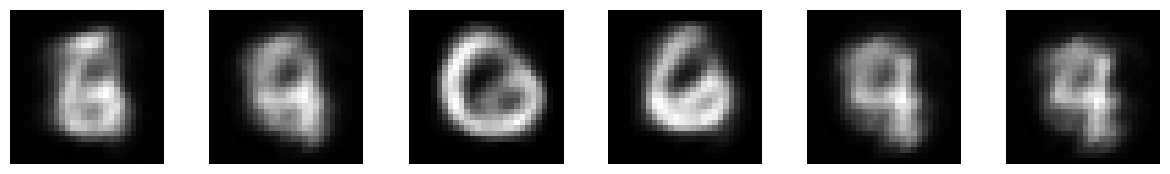


##################################################
VAE-MLP Epoch [2/10], Loss: 143967.73340833333
Sample Images:


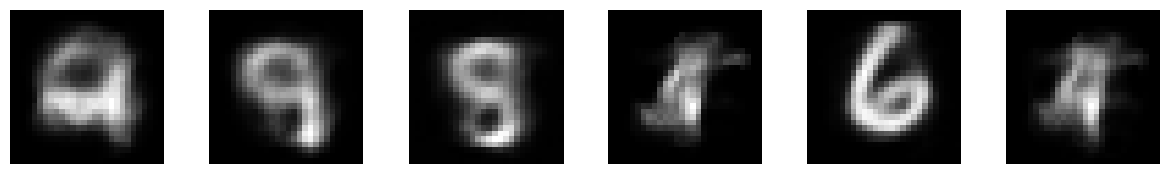


##################################################
VAE-MLP Epoch [3/10], Loss: 136097.93533333333
Sample Images:


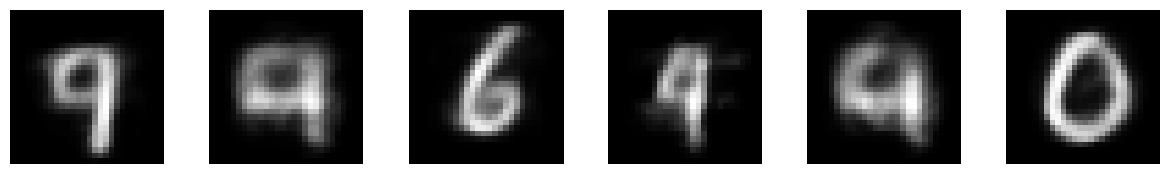


##################################################
VAE-MLP Epoch [4/10], Loss: 131784.21583333332
Sample Images:


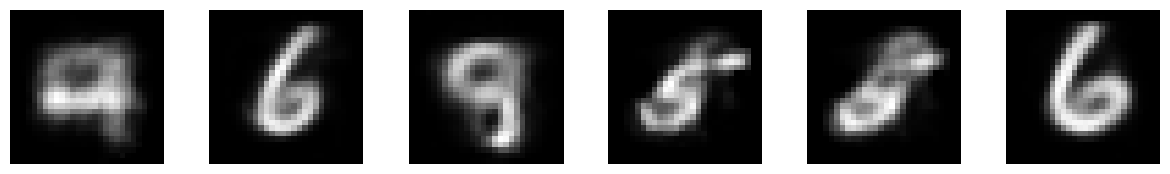


##################################################
VAE-MLP Epoch [5/10], Loss: 128968.83314583333
Sample Images:


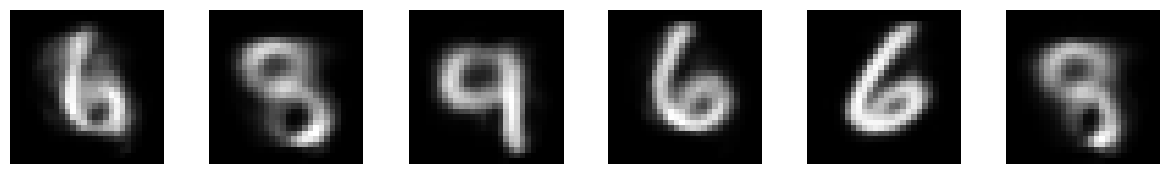


##################################################
VAE-MLP Epoch [6/10], Loss: 126833.84695
Sample Images:


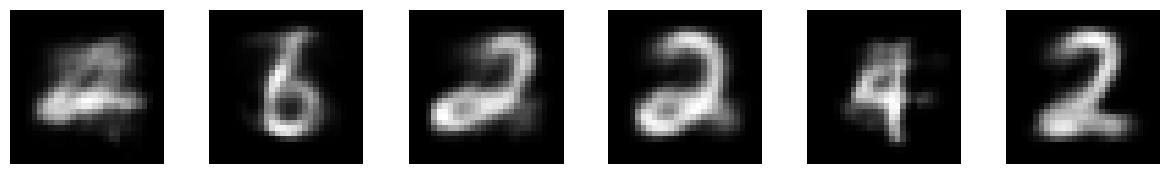


##################################################
VAE-MLP Epoch [7/10], Loss: 125172.72951666667
Sample Images:


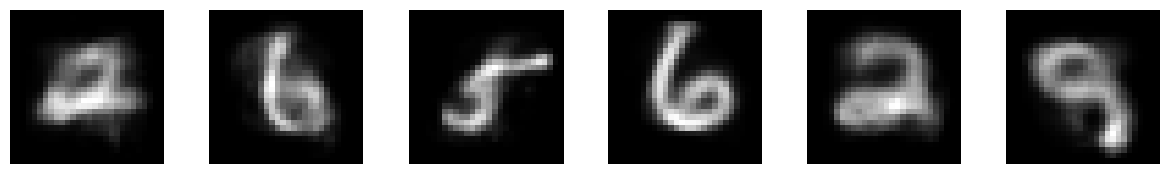


##################################################
VAE-MLP Epoch [8/10], Loss: 123787.22522083334
Sample Images:


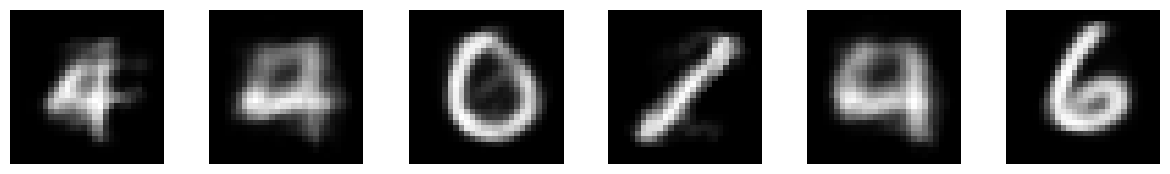


##################################################
VAE-MLP Epoch [9/10], Loss: 122721.61489583334
Sample Images:


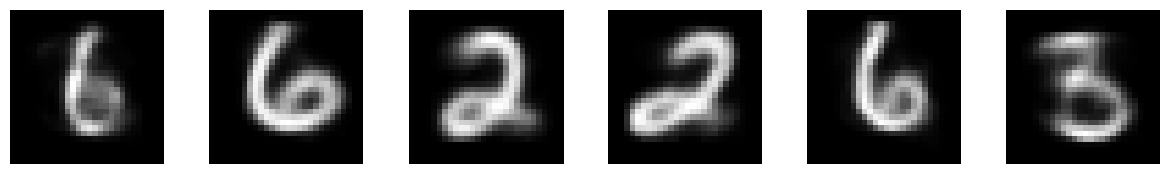


##################################################
VAE-MLP Epoch [10/10], Loss: 121738.41606666667
Sample Images:


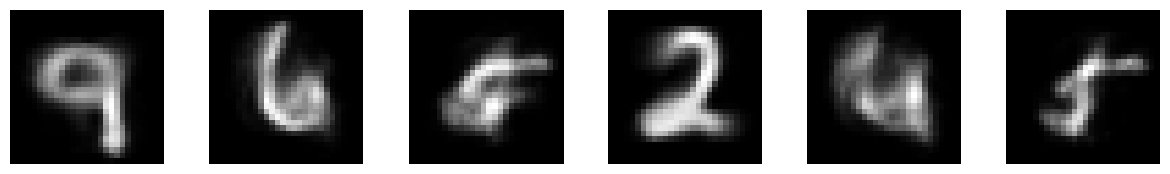

Best model saved as 'best_vae_mlp_model.pth'


In [8]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=64, latent_dim=2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [9]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim + num_classes, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200 , hidden_dim),
            nn.ReLU()         
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim + num_classes, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400 , input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        return mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim=1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        reconstructed = self.decoder(torch.cat([z, y], dim=1))

        return reconstructed, mu, logvar, class_logits


In [10]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(-1)
    recon = recon.view(-1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + 2*kl_divergence + ce_loss


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        model = model.to(device)
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            data , labels = data.to(device), labels.to(device)
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1).to(device)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################


CVAE-MLP Epoch [1/10], Loss: 346.71617635091144
Sample Images:


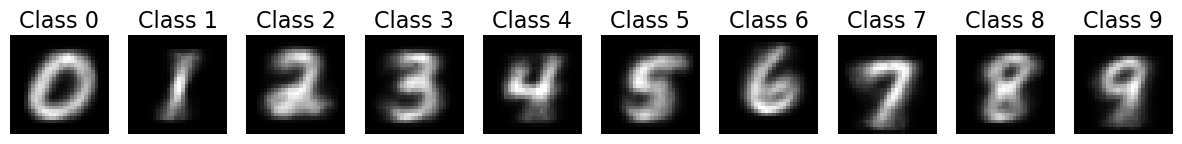


##################################################
CVAE-MLP Epoch [2/10], Loss: 177.00848657226564
Sample Images:


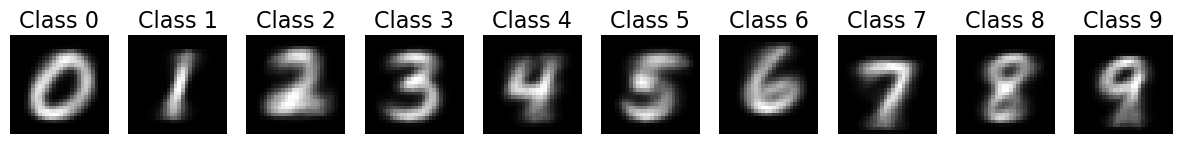


##################################################
CVAE-MLP Epoch [3/10], Loss: 176.7333978841146
Sample Images:


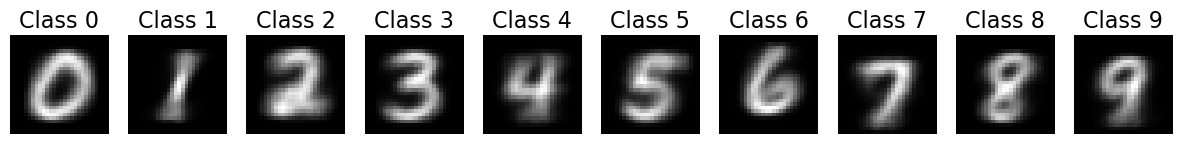


##################################################
CVAE-MLP Epoch [4/10], Loss: 176.80608936360676
Sample Images:


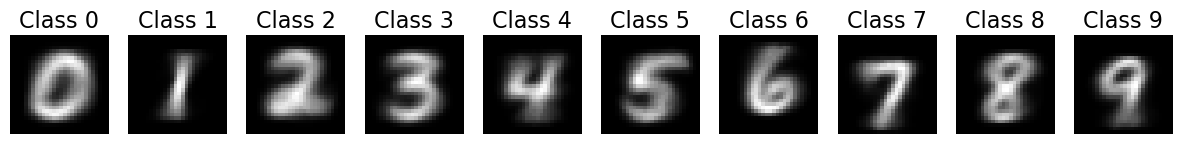


##################################################
CVAE-MLP Epoch [5/10], Loss: 176.66977356770835
Sample Images:


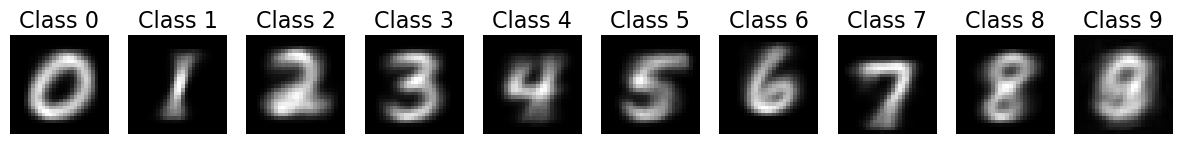


##################################################
CVAE-MLP Epoch [6/10], Loss: 176.46477580566406
Sample Images:


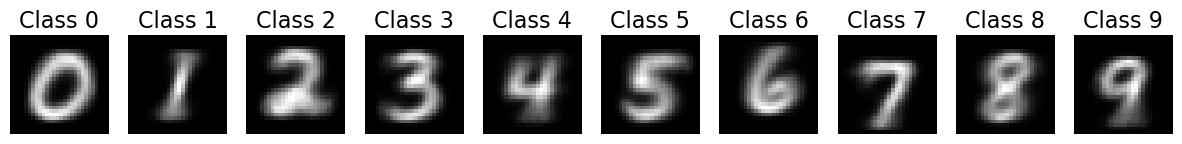


##################################################
CVAE-MLP Epoch [7/10], Loss: 176.61576830240887
Sample Images:


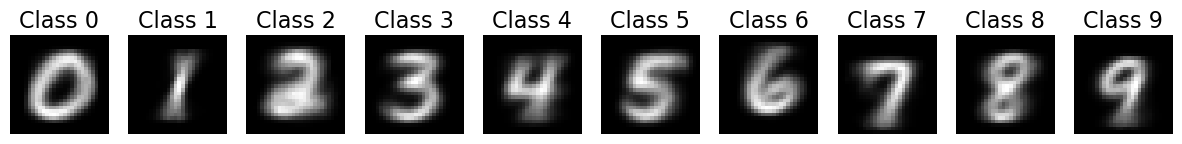


##################################################
CVAE-MLP Epoch [8/10], Loss: 176.68493853352865
Sample Images:


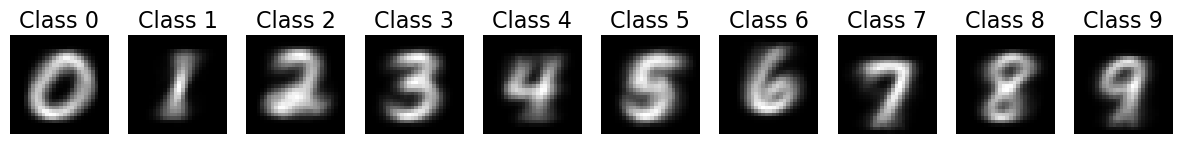


##################################################
CVAE-MLP Epoch [9/10], Loss: 176.41325427246093
Sample Images:


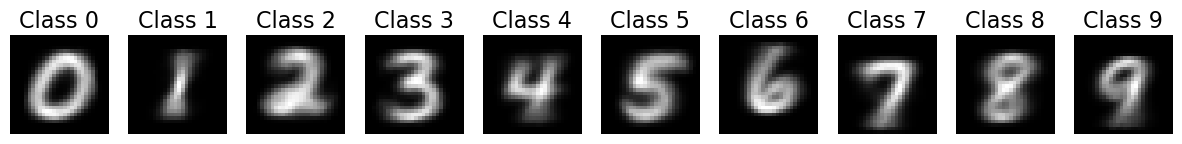


##################################################
CVAE-MLP Epoch [10/10], Loss: 176.61407626139322
Sample Images:


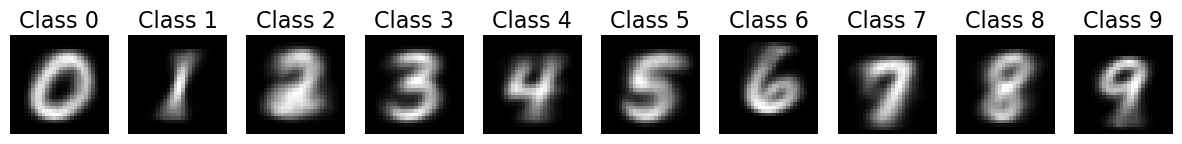

Best model saved as 'best_cvae_mlp_model.pth'


In [13]:
cvae_mlp = CVAE_MLP(input_dim=784, hidden_dim=64, latent_dim=2, num_classes=10)
train_cvae_mlp(cvae_mlp, train_loader,learning_rate=5e-2)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


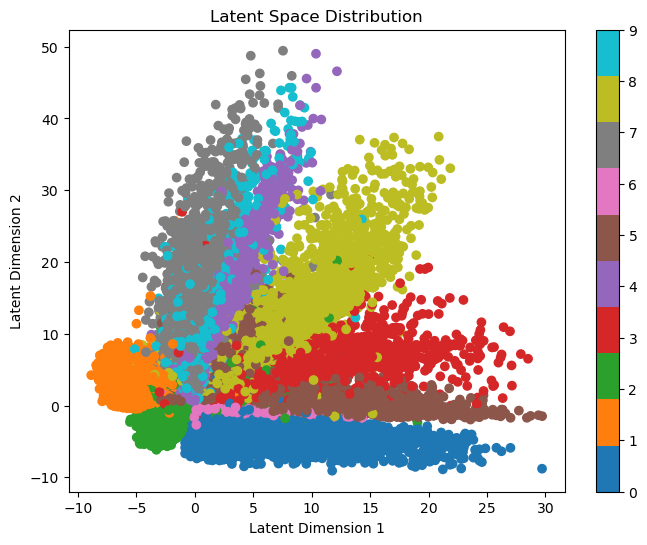

In [14]:
# Function to visualize the latent space distribution
def visualize_latent_space(vae_model, data_loader):
    vae_model = vae_model.to(device)
    vae_model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            recon, mu, logvar = vae_model(data)
            latent_vectors.append(mu.cpu().numpy())
            labels.append(label.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Plot the latent space distribution
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Distribution')
    plt.show()

# Call the function to visualize the latent space distribution
visualize_latent_space(vae_mlp, train_loader)


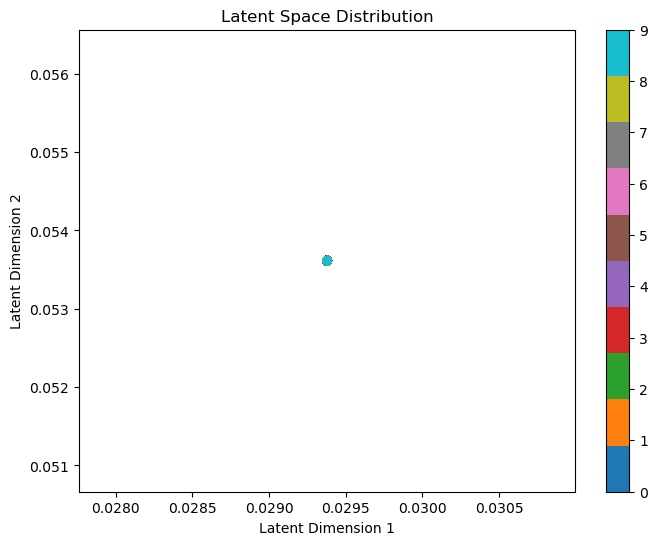

In [19]:
# Function to visualize the latent space distribution
def visualize_latent_space(cvae_model, data_loader):
    cvae_model = cvae_model.to(device)
    cvae_model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            label = label.to(device)
            # One-hot encode the labels
            labels_one_hot = F.one_hot(label, num_classes=10).float()
            recon, mu, logvar, class_logits = cvae_model(data, labels_one_hot)
            latent_vectors.append(mu.cpu().numpy())
            labels.append(label.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Plot the latent space distribution
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Distribution')
    plt.show()

# Call the function to visualize the latent space distribution
visualize_latent_space(cvae_mlp, train_loader)

#Becuse of big KL divergence loss, the latent space distribution is not clear.


As it's obvious from the above figures, the latent space distribution for the VAE model is more uniform and the data points are more spread out. On the other hand, the latent space distribution for the CVAE model is more concentrated and the data points are more clustered. This is because the CVAE model is conditioned on the labels and the latent space distribution is conditioned on the labels as well. Therefore, the latent space distribution for the CVAE model is more concentrated and the data points are more clustered.